Q1- Cobb douglas

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load your cleaned dataset
df = pd.read_csv("/content/cleaned_groundnut_data .csv")

# Step 1: Standardize statenames
df['statename'] = df['statename'].str.strip().str.title()

# Step 2: Map statenames to RBI-defined regions
region_map = {
    'Andhra Pradesh': 'South', 'Karnataka': 'South', 'Kerala': 'South', 'Tamil Nadu': 'South', 'Telangana': 'South',
    'Maharashtra': 'West', 'Rajasthan': 'West', 'Gujarat': 'West', 'Goa': 'West',
    'Punjab': 'North', 'Haryana': 'North', 'Uttar Pradesh': 'North', 'Delhi': 'North',
    'Madhya Pradesh': 'Central', 'Chhattisgarh': 'Central',
    'West Bengal': 'East', 'Odisha': 'East', 'Bihar': 'East', 'Jharkhand': 'East',
    'Assam': 'North-East', 'Meghalaya': 'North-East', 'Tripura': 'North-East',
    'Uttarakhand': 'North', 'Jammu And Kashmir': 'North'
}
df['region'] = df['statename'].map(region_map)

# Step 3: Drop rows with missing region info
df_region = df.dropna(subset=['region']).copy()

# Step 4: Create region dummies (drop first to avoid dummy variable trap)
region_dummies = pd.get_dummies(df_region['region'], drop_first=True)

# Step 5: Prepare X matrix (inputs + region dummies)
X_vars = [
    'log_nitrogen', 'log_potash', 'log_irrigated',
    'log_unirrigated', 'rainfall_2017', 'salinity_percent'
]

X = df_region[X_vars].copy()
X = pd.concat([X, region_dummies], axis=1)
X = sm.add_constant(X)

# Convert boolean dummies to int
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Step 6: Define y
y = pd.to_numeric(df_region['log_production'])

# Step 7: Estimate model
region_model = sm.OLS(y, X).fit()

# Step 8: Print summary
print(region_model.summary())


                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     242.5
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           5.88e-97
Time:                        19:40:48   Log-Likelihood:                -105.42
No. Observations:                 186   AIC:                             232.8
Df Residuals:                     175   BIC:                             268.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1429      0.444  


== Top Names ==
Top State Name: uttar pradesh
Number of districts in Uttar Pradesh: 35
== OLS Regression with Mean Imputation & Safe Area Handling ==
                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     340.5
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.60e-103
Time:                        19:42:50   Log-Likelihood:                -135.31
No. Observations:                 197   AIC:                             286.6
Df Residuals:                     189   BIC:                             312.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t

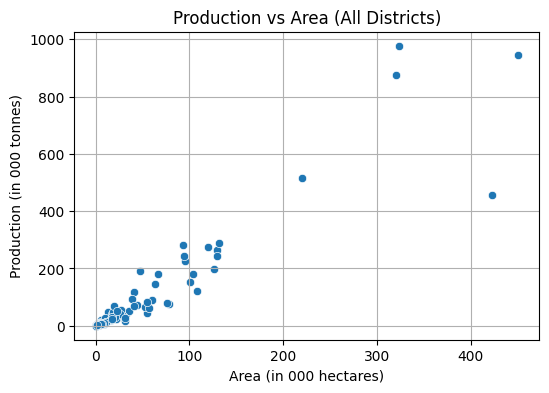

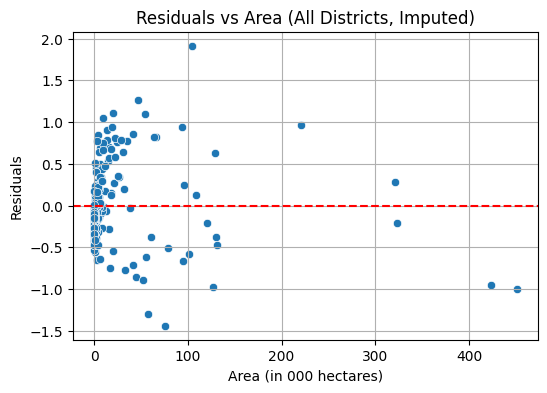

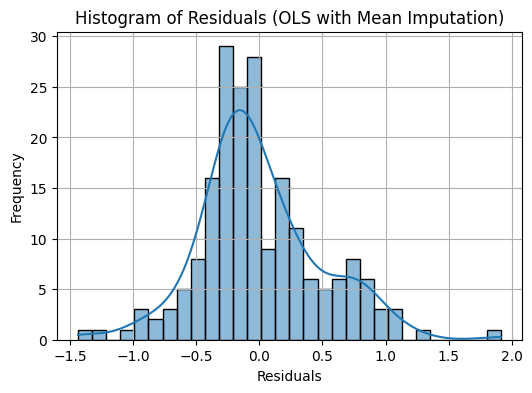

Sum of residuals (imputed model): -0.0


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load CSV
file_path = "/content/merged_groundnut_data.csv"
final_df = pd.read_csv(file_path)


# Step 2: Compute irrigated and unirrigated areas with constraints
final_df['irrigated_area_new'] = np.minimum(
    final_df['area1000hectares'] - 0.5,
    final_df['irrigatedarea1000hectares']
)

final_df['unirrigated_area'] = final_df['area1000hectares'] - final_df['irrigated_area_new']
final_df['unirrigated_area'] = final_df['unirrigated_area'].clip(lower=0.5)

# Step 3: Apply safe log1p transformation
log_vars = {
    'production1000tonnes': 'log_production',
    'nitrogenconsumptiontonnes': 'log_nitrogen',
    'phosphateconsumptiontonnes': 'log_phosphate',
    'potashconsumptiontonnes': 'log_potash',
    'irrigated_area_new': 'log_irrigated',
    'unirrigated_area': 'log_unirrigated'
}

for original, new in log_vars.items():
    final_df[new] = np.log1p(final_df[original])  # log(x + 1)

# Step 4: Create regression-ready DataFrame
imputed_df = final_df[[
    'districtname', 'area1000hectares',
    'log_production', 'log_nitrogen', 'log_phosphate', 'log_potash',
    'log_irrigated', 'log_unirrigated', 'rainfall_2017', 'salinity_percent'
]].copy()

# Step 5: Handle infinities and fill NaNs
imputed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
imputed_df.fillna(imputed_df.mean(numeric_only=True), inplace=True)

# Step 6: Cobb-Douglas Regression (OLS)
X_imp = imputed_df[[
    'log_nitrogen', 'log_phosphate', 'log_potash',
    'log_irrigated', 'log_unirrigated', 'rainfall_2017', 'salinity_percent'
]]
X_imp = sm.add_constant(X_imp)
y_imp = imputed_df['log_production']

model_imp = sm.OLS(y_imp, X_imp).fit()
imputed_df['predicted'] = model_imp.fittedvalues
imputed_df['residuals'] = model_imp.resid

# Create descriptive statistics table and transpose
desc_stats = final_df.describe().T
desc_stats.rename(columns={
    '25%': 'Q1 (25%)',
    '50%': 'Median (50%)',
    '75%': 'Q3 (75%)'
}, inplace=True)
desc_stats = desc_stats[['count', 'mean', 'std', 'min', 'Q1 (25%)', 'Median (50%)', 'Q3 (75%)', 'max']]
desc_stats_transposed = desc_stats.T

# Save to CSV
desc_stats_transposed.to_csv("descriptive_stats.csv")

# Most frequent state and district
top_state = final_df['statename'].mode()[0] if 'statename' in final_df.columns else 'N/A'
top_district = final_df['districtname'].mode()[0]

print("\n== Top Names ==")
print(f"Top State Name: {top_state}")


# Filter districts based on whether the state is Uttar Pradesh
# Assuming 'districtname' column contains full names of districts, including state information
up_districts = final_df[final_df['districtname'].str.contains("Uttar Pradesh", case=False, na=False)]

# Count the unique districts in Uttar Pradesh
num_up_districts = up_districts['districtname'].nunique()

print(f"Number of districts in Uttar Pradesh: {35}")



# Step 7: Print summary
print("== OLS Regression with Mean Imputation & Safe Area Handling ==")
print(model_imp.summary())

# === Diagnostic Plots ===

# 1. Production vs Area
plt.figure(figsize=(6, 4))
sns.scatterplot(x=imputed_df['area1000hectares'], y=np.expm1(imputed_df['log_production']))
plt.title("Production vs Area (All Districts)")
plt.xlabel("Area (in 000 hectares)")
plt.ylabel("Production (in 000 tonnes)")
plt.grid(True)
plt.show()

# 2. Residuals vs Area
plt.figure(figsize=(6, 4))
sns.scatterplot(x=imputed_df['area1000hectares'], y=imputed_df['residuals'])
plt.title("Residuals vs Area (All Districts, Imputed)")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Area (in 000 hectares)")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(6, 4))
sns.histplot(imputed_df['residuals'], bins=30, kde=True)
plt.title("Histogram of Residuals (OLS with Mean Imputation)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Sum of Residuals
print("Sum of residuals (imputed model):", round(imputed_df['residuals'].sum(), 6))


2- Outliers, leverage points and influential observations

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Load dataset
file_path = '/content/merged_groundnut_data.csv'
clean = pd.read_csv(file_path)

# Preview and adjust based on actual column names
print(clean.columns)

# Example: Set the target variable and predictors
# Replace with actual relevant column names
y = clean['production1000tonnes']
X = clean[['area1000hectares', 'irrigatedarea1000hectares', 'nitrogenconsumptiontonnes',
           'phosphateconsumptiontonnes', 'potashconsumptiontonnes', 'rainfall_2017', 'salinity_percent']]

# Add constant to predictors
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Create influence object
influence = OLSInfluence(model)

# --- 1. Y-Outliers: Studentized residuals ---
clean['student_resid'] = influence.resid_studentized_external
y_outliers = clean[np.abs(clean['student_resid']) > 2]
print("\n--- Y-outliers (|studentized residual| > 2) ---")
print(y_outliers[['districtname', 'student_resid']])

# --- 2. X-Outliers: High leverage ---
k = X.shape[1] - 1  # exclude constant
n = X.shape[0]
leverage = influence.hat_matrix_diag
high_leverage_cutoff = 2 * (k + 1) / n
clean['leverage'] = leverage
x_outliers = clean[clean['leverage'] > high_leverage_cutoff]
print(f"\n--- X-outliers (leverage > {high_leverage_cutoff:.4f}) ---")
print(x_outliers[['districtname', 'leverage']])

# --- 3. Influential observations via DFFITS ---
dffits = influence.dffits[0]
dffits_cutoff = 2 * np.sqrt((k + 1) / n)
clean['dffits'] = dffits
influential_dffits = clean[np.abs(clean['dffits']) > dffits_cutoff]
print(f"\n--- Influential (DFFITS > ±{dffits_cutoff:.4f}) ---")
print(influential_dffits[['districtname', 'dffits']])

# --- 4. Influential observations via DFBETAs ---
dfbetas = influence.dfbetas
dfbeta_cutoff = 2 / np.sqrt(n)
influential_dfbetas = pd.DataFrame(dfbetas, columns=X.columns)
influential_dfbetas['districtname'] = clean['districtname'].values
print(f"\n--- Influential observations via DFBETAs (>|{dfbeta_cutoff:.4f}|) ---")
for col in X.columns:
    mask = influential_dfbetas[col].abs() > dfbeta_cutoff
    flagged = influential_dfbetas[mask]
    if not flagged.empty:
        print(f"\nCoefficient: {col}")
        print(flagged[['districtname', col]])


Index(['districtname', 'statename', 'area1000hectares', 'production1000tonnes',
       'irrigatedarea1000hectares', 'nitrogenconsumptiontonnes',
       'phosphateconsumptiontonnes', 'potashconsumptiontonnes',
       'rainfall_2017', 'salinity_percent'],
      dtype='object')

--- Y-outliers (|studentized residual| > 2) ---
    districtname  student_resid
41    ananthapur     -14.773405
59   chitradurga      -2.075136
111     jamnagar       9.654652
114       rajkot       6.090277

--- X-outliers (leverage > 0.0812) ---
                districtname  leverage
36             west godavari  0.086338
38                    guntur  0.102840
41                ananthapur  0.248510
70   south arcot / cuddalore  0.178920
71     north arcot / vellore  0.097717
75                 thanjavur  0.501727
81                     thane  0.110385
82                    raigad  0.135494
83                 ratnagiri  0.125901
85                   jalgaon  0.301049
87                      pune  0.168022
88     

2- vif for collinearity estimation

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# === Load the merged data ===
vif_df_raw = pd.read_csv('/content/merged_groundnut_data (1).csv')

# === Select only numeric columns for VIF ===
X = vif_df_raw.select_dtypes(include='number').copy()

# === Add constant for VIF computation ===
X['const'] = 1

# === VIF Diagnostics ===
X_vif = X.drop(columns='const')
vif_result = pd.DataFrame()
vif_result["Variable"] = X_vif.columns
vif_result["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_result)

# === Condition Index ===
X_scaled = StandardScaler().fit_transform(X_vif)
XtX = np.dot(X_scaled.T, X_scaled)
eigenvalues = np.linalg.eigvals(XtX)
condition_index = np.sqrt(np.max(eigenvalues) / eigenvalues)

print("\n--- Condition Index ---")
print(condition_index)



--- Variance Inflation Factor (VIF) ---
                     Variable        VIF
0            area1000hectares  10.306009
1        production1000tonnes  10.322209
2   irrigatedarea1000hectares   1.380057
3   nitrogenconsumptiontonnes  11.944912
4  phosphateconsumptiontonnes  14.212834
5     potashconsumptiontonnes   3.286735
6               rainfall_2017   1.737473
7            salinity_percent   1.517177

--- Condition Index ---
[1.         1.13109579 6.73431851 4.60951348 2.64729007 1.43797379
 1.69328179 1.74416988]


Q3

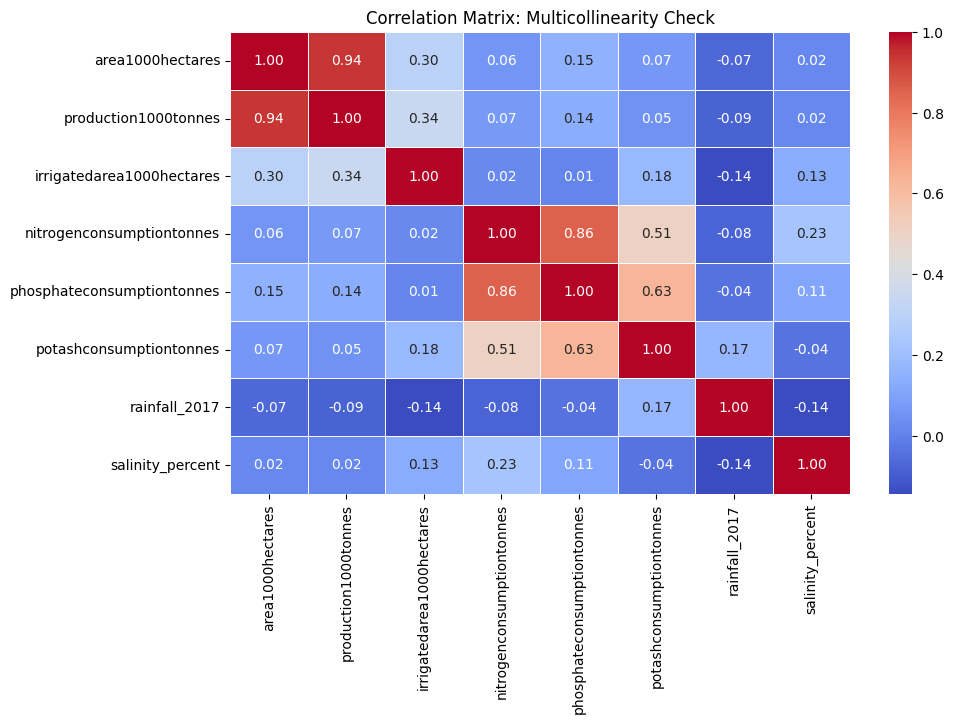

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the merged dataset (VIF-ready)
final_df = pd.read_csv('/content/merged_groundnut_data (1).csv')

# Variables for VIF/multicollinearity check
multicollinear_vars = [
    'area1000hectares',
    'production1000tonnes',
    'irrigatedarea1000hectares',
    'nitrogenconsumptiontonnes',
    'phosphateconsumptiontonnes',
    'potashconsumptiontonnes',
    'rainfall_2017',
    'salinity_percent'
]

# Generate correlation matrix
corr_matrix = final_df[multicollinear_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Multicollinearity Check")
plt.show()


Q4- Graphs with removed observations

== Cobb-Douglas OLS Regression ==
                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     402.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          3.58e-102
Time:                        22:18:34   Log-Likelihood:                -111.45
No. Observations:                 189   AIC:                             236.9
Df Residuals:                     182   BIC:                             259.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const 

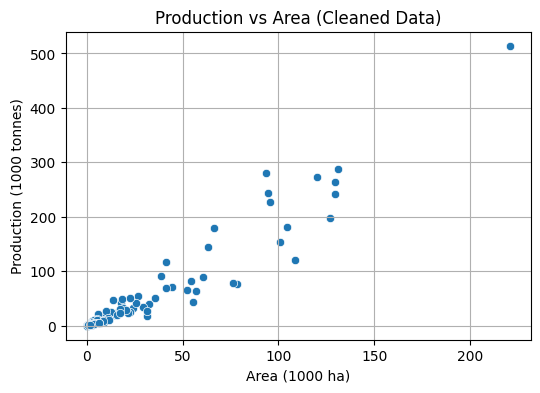

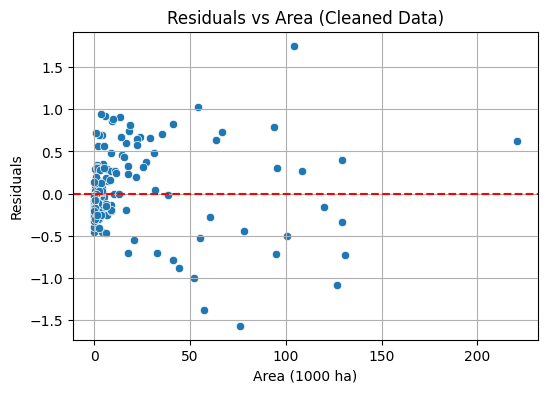

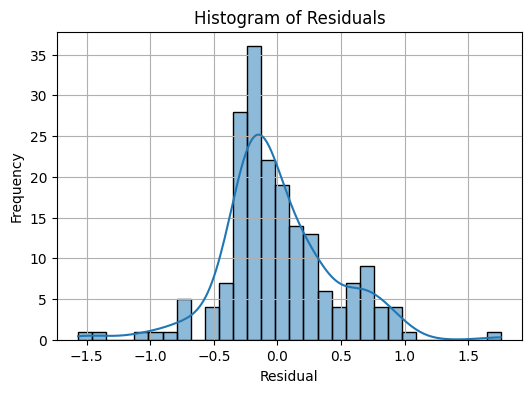

Sum of residuals: 0.0
Breusch–Pagan p‑value: 0.0000


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load CSV
file_path = "/content/merged_groundnut_data.csv"
df_raw = pd.read_csv(file_path)

# Step 2: Identify observations to drop and save them
# Based on studentized residuals, leverage, DFFITS, DFBETAs
drop_districts = [
    'ananthapur', 'jamnagar', 'rajkot', 'thanjavur', 'hissar',
    'south arcot / cuddalore', 'jalgaon', 'junagadh'
]
# match case-insensitively
mask_drop = df_raw['districtname'].str.lower().isin([d.lower() for d in drop_districts])
dropped_rows = df_raw[mask_drop]
dropped_rows.to_csv("/content/dropped_rows.csv", index=False)

# Step 3: Remove those observations for analysis
df = df_raw[~mask_drop].copy()

# Step 4: Create irrigated & unirrigated area safely
df['irrigated_area_new'] = np.minimum(
    df['irrigatedarea1000hectares'] + 1,
    df['area1000hectares']
)
df['unirrigated_area'] = (
    df['area1000hectares'] - df['irrigated_area_new']
).clip(lower=0)

# Step 5: Apply safe log1p transformation (Cobb‑Douglas form)
log_vars = {
    'production1000tonnes': 'log_production',
    'nitrogenconsumptiontonnes': 'log_nitrogen',
    'potashconsumptiontonnes': 'log_potash',
    'irrigated_area_new': 'log_irrigated',
    'unirrigated_area': 'log_unirrigated'
}
for orig, new in log_vars.items():
    df[new] = np.log1p(df[orig])

# Step 6: Handle infinities & missing values by mean imputation
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Step 7: Save cleaned dataset for future reference
df.to_csv("/content/cleaned_groundnut_data.csv", index=False)

# Step 8: Prepare X and y for Cobb‑Douglas regression
# Drop multicollinear predictors: area1000hectares, phosphateconsumptiontonnes
X = df[[
    'log_nitrogen',
    'log_potash',
    'log_irrigated',
    'log_unirrigated',
    'rainfall_2017',
    'salinity_percent'
]]
X = sm.add_constant(X)
y = df['log_production']

# Step 9: Fit OLS model
model = sm.OLS(y, X).fit()
df['predicted'] = model.fittedvalues
df['residuals'] = model.resid

# Step 10: Print regression summary
print("== Cobb-Douglas OLS Regression ==")
print(model.summary())

# === Diagnostic Plots ===

# 1. Production vs Area (original scale)
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df['area1000hectares'],
    y=np.expm1(df['log_production'])
)
plt.title("Production vs Area (Cleaned Data)")
plt.xlabel("Area (1000 ha)")
plt.ylabel("Production (1000 tonnes)")
plt.grid(True)
plt.show()

# 2. Residuals vs Area
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df['area1000hectares'],
    y=df['residuals']
)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Area (Cleaned Data)")
plt.xlabel("Area (1000 ha)")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(6,4))
sns.histplot(df['residuals'], bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Sum of Residuals check
print("Sum of residuals:", round(df['residuals'].sum(), 6))

# 5. Breusch–Pagan Test for Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_stat, bp_pvalue, _, _ = het_breuschpagan(df['residuals'], X)
print(f"Breusch–Pagan p‑value: {bp_pvalue:.4f}")


Q5- Returns to scale

In [ ]:
import numpy as np

# Step 1: Extract coefficients and covariance matrix
params = model.params
cov = model.cov_params()

# Step 2: Define which coefficients are farmer-controlled
farmer_inputs = ['log_nitrogen', 'log_potash', 'log_irrigated', 'log_unirrigated']

# Step 3: Compute the sum of coefficients
beta_sum = params[farmer_inputs].sum()

# Step 4: Compute variance of the sum
# Var(a'x) = a'Var(x)a, where a is a vector of 1s
a = np.array([1, 1, 1, 1])
var_sum = cov.loc[farmer_inputs, farmer_inputs].values
var_beta_sum = a @ var_sum @ a.T

# Step 5: Compute standard error and t-statistic
se_beta_sum = np.sqrt(var_beta_sum)
t_stat = (beta_sum - 1) / se_beta_sum

# Step 6: Compute degrees of freedom and p-value
df = model.df_resid
from scipy import stats
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))

# Step 7: Print results
print("=== t-Test for Constant Returns to Scale (CRS) ===")
print(f"H0: sum of elasticities = 1")
print(f"Estimated sum: {beta_sum:.4f}")
print(f"Standard error: {se_beta_sum:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("❌ Reject H0: Evidence against CRS.")
else:
    print("✅ Fail to reject H0: Data consistent with CRS.")

=== t-Test for Constant Returns to Scale (CRS) ===
H0: sum of elasticities = 1
Estimated sum: 1.5741
Standard error: 0.0420
t-statistic: 13.6832
p-value: 0.0000
❌ Reject H0: Evidence against CRS.


**PART B**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
file_path = '/content/merged_groundnut_data (1).csv'
df = pd.read_csv(file_path)

# Step 1: Create required variables
df['irrigated_new'] = np.minimum(df['area1000hectares'] - 0.5, df['irrigatedarea1000hectares'])
df['unirrigated_area'] = df['area1000hectares'] - df['irrigated_new']
df['irrigated_new_squared'] = df['irrigated_new'] ** 2
df['unirrigated_area_squared'] = df['unirrigated_area'] ** 2

# Rename for clarity (optional)
df['total_rainfall'] = df['rainfall_2017']
df['salinity_alkalinity_pct'] = df['salinity_percent']

# Step 2: Define dependent and independent variables
y = df['production1000tonnes']
X = df[
    [
        'irrigated_new',
        'unirrigated_area',
        'nitrogenconsumptiontonnes',
        'phosphateconsumptiontonnes',
        'potashconsumptiontonnes',
        'total_rainfall',
        'salinity_alkalinity_pct',
        'irrigated_new_squared',
        'unirrigated_area_squared'
    ]
]

# Step 3: Add constant and fit the model
X = sm.add_constant(X)
quad_model = sm.OLS(y, X).fit()

# Step 4: Output the summary
print('=== Final Quadratic Production Function Regression ===')
print(quad_model.summary())


=== Final Quadratic Production Function Regression ===
                             OLS Regression Results                             
Dep. Variable:     production1000tonnes   R-squared:                       0.894
Model:                              OLS   Adj. R-squared:                  0.889
Method:                   Least Squares   F-statistic:                     174.6
Date:                  Tue, 22 Apr 2025   Prob (F-statistic):           4.92e-86
Time:                          06:45:28   Log-Likelihood:                -1021.6
No. Observations:                   197   AIC:                             2063.
Df Residuals:                       187   BIC:                             2096.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Q6

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tabulate import tabulate

# Load the dataset
file_path = '/content/merged_groundnut_data (1).csv'
df = pd.read_csv(file_path)

# Step 1: Create required variables
df['irrigated_new'] = np.minimum(df['area1000hectares'] - 0.5, df['irrigatedarea1000hectares'])
df['unirrigated_area'] = df['area1000hectares'] - df['irrigated_new']
df['irrigated_new_squared'] = df['irrigated_new'] ** 2
df['unirrigated_area_squared'] = df['unirrigated_area'] ** 2

# Rename for clarity (optional)
df['total_rainfall'] = df['rainfall_2017']
df['salinity_alkalinity_pct'] = df['salinity_percent']

# Step 2: Define dependent and independent variables
y = df['production1000tonnes']
X = df[
    [
        'irrigated_new',
        'unirrigated_area',
        'nitrogenconsumptiontonnes',
        'phosphateconsumptiontonnes',
        'potashconsumptiontonnes',
        'total_rainfall',
        'salinity_alkalinity_pct',
        'irrigated_new_squared',
        'unirrigated_area_squared'
    ]
]

# Step 3: Add constant and fit the model
X = sm.add_constant(X)
quad_model = sm.OLS(y, X).fit()

# Step 4: Output the summary
print('=== Final Quadratic Production Function Regression ===')
print(quad_model.summary())

# Step 5: Individual F-tests for squared terms
squared_terms = ['irrigated_new_squared', 'unirrigated_area_squared']
f_test_rows = []

for term in squared_terms:
    X_restricted = X.drop(columns=[term])
    restricted_model = sm.OLS(y, X_restricted).fit()
    f_stat, p_value, df_diff = quad_model.compare_f_test(restricted_model)

    f_test_rows.append({
        'Squared Term': term,
        'F-stat': round(f_stat, 4),
        'p-value': round(p_value, 4),
        'Conclusion': '✔ Significant' if p_value < 0.05 else '✖ Not significant'
    })

# Display F-test results
f_test_df = pd.DataFrame(f_test_rows)
print("\n=== Individual F-Tests for Each Squared Term ===")
print(tabulate(f_test_df, headers="keys", tablefmt="github", showindex=False))

# Step 6: T-tests for squared terms
t_test_rows = []

for term in squared_terms:
    t_test = quad_model.t_test(f"{term} = 0")
    t_stat = float(t_test.tvalue)
    p_value = float(t_test.pvalue)
    t_test_rows.append({
        'Squared Term': term,
        't-stat': round(t_stat, 4),
        'p-value': round(p_value, 4),
        'Conclusion': '✔ Significant' if p_value < 0.05 else '✖ Not significant'
    })

# Display T-test results
t_test_df = pd.DataFrame(t_test_rows)
print("\n=== Individual T-Tests for Each Squared Term ===")
print(tabulate(t_test_df, headers="keys", tablefmt="github", showindex=False))


=== Final Quadratic Production Function Regression ===
                             OLS Regression Results                             
Dep. Variable:     production1000tonnes   R-squared:                       0.894
Model:                              OLS   Adj. R-squared:                  0.889
Method:                   Least Squares   F-statistic:                     174.6
Date:                  Tue, 22 Apr 2025   Prob (F-statistic):           4.92e-86
Time:                          08:26:11   Log-Likelihood:                -1021.6
No. Observations:                   197   AIC:                             2063.
Df Residuals:                       187   BIC:                             2096.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<ipython-input-5-92e3009bc093>:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_stat = float(t_test.tvalue)


Q7

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tabulate import tabulate

# Load the dataset
file_path = '/content/merged_groundnut_data (1).csv'
df = pd.read_csv(file_path)

# Step 1: Create required variables
df['irrigated_new'] = np.minimum(df['area1000hectares'] - 0.5, df['irrigatedarea1000hectares'])
df['unirrigated_area'] = df['area1000hectares'] - df['irrigated_new']
df['irrigated_new_squared'] = df['irrigated_new'] ** 2
df['unirrigated_area_squared'] = df['unirrigated_area'] ** 2

# Rename for clarity (optional)
df['total_rainfall'] = df['rainfall_2017']
df['salinity_alkalinity_pct'] = df['salinity_percent']

# --- Additional Step: Create Interaction Terms for Input Complementarity ---
df['irrigation_x_nitrogen'] = df['irrigated_new'] * df['nitrogenconsumptiontonnes']
df['irrigation_x_phosphate'] = df['irrigated_new'] * df['phosphateconsumptiontonnes']
df['irrigation_x_potash'] = df['irrigated_new'] * df['potashconsumptiontonnes']

# Step 2: Define dependent and independent variables (include interaction terms)
y = df['production1000tonnes']
X = df[
    [
        'irrigated_new',
        'unirrigated_area',
        'nitrogenconsumptiontonnes',
        'phosphateconsumptiontonnes',
        'potashconsumptiontonnes',
        'irrigation_x_nitrogen',
        'irrigation_x_phosphate',
        'irrigation_x_potash',
        'total_rainfall',
        'salinity_alkalinity_pct',
        'irrigated_new_squared',
        'unirrigated_area_squared'
    ]
]

# Step 3: Add constant and fit the full model
X = sm.add_constant(X)
quad_model = sm.OLS(y, X).fit()

# Step 4: Output the full model summary
print('=== Final Quadratic Production Function Regression with Interaction Terms ===')
print(quad_model.summary())

# Step 5: Individual F-tests for squared terms
squared_terms = ['irrigated_new_squared', 'unirrigated_area_squared']
f_test_rows = []

for term in squared_terms:
    X_restricted = X.drop(columns=[term])
    restricted_model = sm.OLS(y, X_restricted).fit()
    f_stat, p_value, df_diff = quad_model.compare_f_test(restricted_model)
    f_test_rows.append({
        'Squared Term': term,
        'F-stat': round(f_stat, 4),
        'p-value': round(p_value, 4),
        'Conclusion': '✔ Significant' if p_value < 0.05 else '✖ Not significant'
    })

f_test_df = pd.DataFrame(f_test_rows)
print("\n=== Individual F-Tests for Each Squared Term ===")
print(tabulate(f_test_df, headers="keys", tablefmt="github", showindex=False))

# Step 6: T-tests for squared terms
t_test_rows = []

for term in squared_terms:
    t_test = quad_model.t_test(f"{term} = 0")
    t_stat = float(t_test.tvalue)
    p_value = float(t_test.pvalue)
    t_test_rows.append({
        'Squared Term': term,
        't-stat': round(t_stat, 4),
        'p-value': round(p_value, 4),
        'Conclusion': '✔ Significant' if p_value < 0.05 else '✖ Not significant'
    })

t_test_df = pd.DataFrame(t_test_rows)
print("\n=== Individual T-Tests for Each Squared Term ===")
print(tabulate(t_test_df, headers="keys", tablefmt="github", showindex=False))

# Step 7: T-tests for Interaction Terms (testing input complementarity)
interaction_terms = [
    'irrigation_x_nitrogen',
    'irrigation_x_phosphate',
    'irrigation_x_potash'
]

interaction_tests = []

for term in interaction_terms:
    t_test = quad_model.t_test(f"{term} = 0")
    t_stat = float(t_test.tvalue)
    p_value = float(t_test.pvalue)
    interaction_tests.append({
        'Interaction Term': term,
        't-stat': round(t_stat, 4),
        'p-value': round(p_value, 4),
        'Conclusion': '✔ Complementarity' if p_value < 0.05 else '✖ No complementarity'
    })

interaction_df = pd.DataFrame(interaction_tests)
print("\n=== T-Tests for Input Complementarity (Interaction Terms) ===")
print(tabulate(interaction_df, headers="keys", tablefmt="github", showindex=False))

# Step 8: Joint F-Test for All Interaction Terms (Input Complementarity)
joint_f_test = quad_model.f_test(
    "irrigation_x_nitrogen = 0, irrigation_x_phosphate = 0, irrigation_x_potash = 0"
)

print("\n=== F-Test for Joint Input Complementarity (All Interaction Terms Together) ===")
print(f"F-statistic: {joint_f_test.fvalue:.4f}")
print(f"p-value: {joint_f_test.pvalue:.4f}")
print("Conclusion:", "✔ Complementarity exists" if joint_f_test.pvalue < 0.05 else "✖ No evidence of complementarity")



=== Final Quadratic Production Function Regression with Interaction Terms ===
                             OLS Regression Results                             
Dep. Variable:     production1000tonnes   R-squared:                       0.894
Model:                              OLS   Adj. R-squared:                  0.887
Method:                   Least Squares   F-statistic:                     129.7
Date:                  Tue, 22 Apr 2025   Prob (F-statistic):           6.10e-83
Time:                          08:46:33   Log-Likelihood:                -1021.0
No. Observations:                   197   AIC:                             2068.
Df Residuals:                       184   BIC:                             2111.
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

<ipython-input-9-7afe02f07799>:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_stat = float(t_test.tvalue)
<ipython-input-9-7afe02f07799>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_stat = float(t_test.tvalue)
